<a href="https://colab.research.google.com/github/Manas1820/gAn_NuM/blob/master/NumberGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading **MNIST Handwritten Digit** Dataset

In [ ]:
from keras.datasets.mnist import load_data
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


# **Displaying 10 images from MNIST Handwritten Digit**

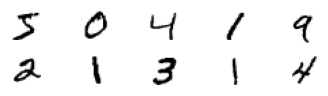

In [ ]:
import matplotlib.pyplot as plt
for i in range(10):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

# **Preparing Dataset for Discriminator Model**

In [ ]:
import numpy as np
dataset = np.expand_dims(trainX, axis=-1)
dataset = dataset.astype('float32')
dataset = dataset / 255.0

# **Defining Discriminator Model**

In [ ]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.3))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.3))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
 
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	ix =np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y =np.ones((n_samples, 1))
	return X, y

def generate_fake_samples(n_samples):
	X = np.random.rand(28 * 28 * n_samples)
	X = X.reshape((n_samples, 28, 28, 1))
	y = np.zeros((n_samples, 1))
	return X, y

# **Defining the Generator**

In [ ]:
from keras.layers import Conv2DTranspose
from keras.layers import Reshape
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# **Defining the GAN**

In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Functions for Summarizing the generated models and plots

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y  

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # To save plot
	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()  

# **Training Our GAN**

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y =np.vstack((X_real, X_fake)),np.vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
d_model = define_discriminator()

g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)